In [0]:
!pip3 install torch

In [0]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
classes = pd.read_csv('/content/drive/My Drive/CS_464_HW3/CUB_200_2011/classes.txt', sep=" ", header=None)[1].values
data_dir = "/content/drive/My Drive/Organised_Dataset_2/"

batch_size = 100
transformation_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 
transformation_valid = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transformation_test = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# importing dataset
train_dataset = datasets.ImageFolder(root= str(data_dir) + "Train",      transform=transformation_train)
valid_dataset = datasets.ImageFolder(root= str(data_dir) + "Validation", transform=transformation_valid)
test_dataset  = datasets.ImageFolder(root= str(data_dir) + "Test",       transform=transformation_test)

# constructing data loaders.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [0]:
print(train_dataset)
print("----------------------------------------------------")
print(valid_dataset)
print("----------------------------------------------------")
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 8190
    Root location: /content/drive/My Drive/Organised_Dataset_2/Train
----------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 2311
    Root location: /content/drive/My Drive/Organised_Dataset_2/Validation
----------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 1227
    Root location: /content/drive/My Drive/Organised_Dataset_2/Test


In [0]:
# plots an image.
def convert_img(tensor_image):
    np_image = tensor_image.clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image


# plots an image.
def convert_img_cuda(tensor_image):
    np_image = tensor_image.cpu().clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

In [0]:
train_iterator = iter(train_loader)
train_images, train_labels = train_iterator.next()
print( train_images.shape )
print( train_labels.shape )

torch.Size([100, 3, 256, 256])
torch.Size([100])


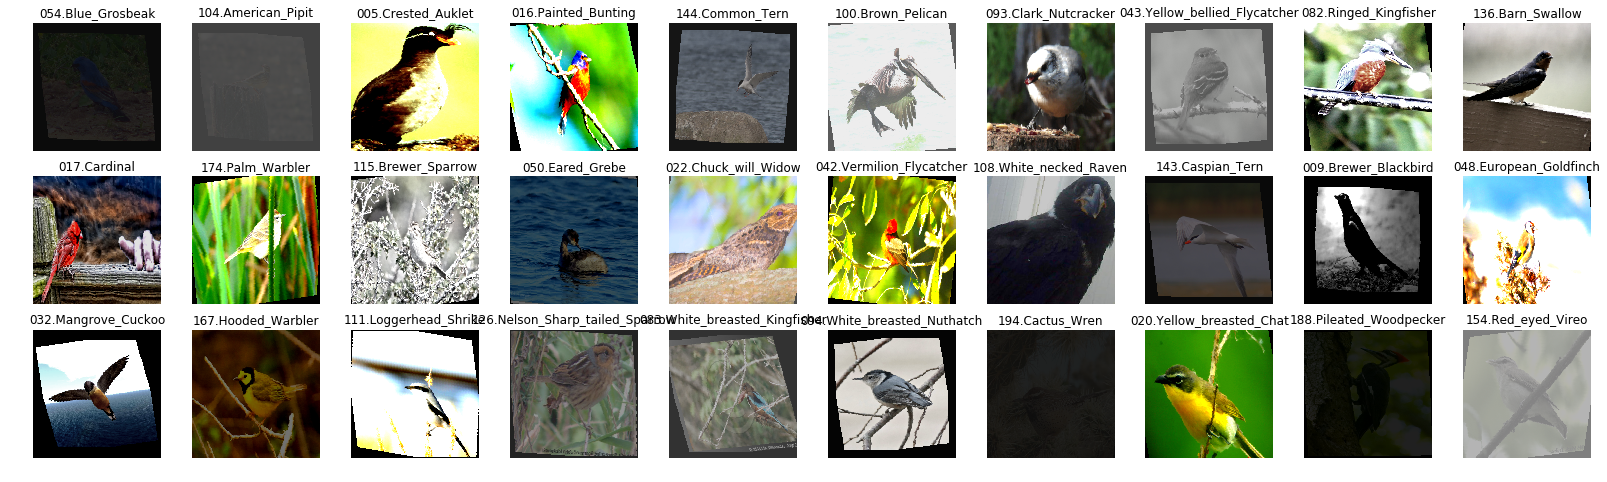

In [0]:
figure = plt.figure(figsize=(28,8))    

for i in range(30):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img(train_images[i])
    title = classes[ train_labels[i] ]
    plt.imshow(image) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [0]:
class ResNet_classifier(nn.Module):
  
    # constructor
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        last_layer_inputs = self.model.fc.in_features
        self.model.fc = nn.Linear(last_layer_inputs, 200)  
        self.model.to(device)

    def propagate_forward(self, x):
        x = self.model.forward(x)
        return x

In [0]:
resnet_model = ResNet_classifier()
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.SGD(resnet_model.parameters(), lr=0.1)

In [0]:
def train_model(criterion, optimizer, model):
    train_loss = 0.0
    train_acc = 0.0
    test_acc_5 = 0.0
  
    # training the model with the train dataset.
    for train_images, train_labels in train_loader:
    
        # registering train images and labels 
        # to device to benefit from GPU
        train_images = train_images.to( device )
        train_labels = train_labels.to( device )   

        # calculating loss for training
        # dataset for the current batch.
        train_labels_head = model.propagate_forward(train_images)
        loss = criterion(train_labels_head, train_labels)

        # updating weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # calculating acurracy for the current
        # batch for the training dataset.
        predictions = torch.max( train_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == train_labels )
        
        # summing training acurracy and 
        # loss wit the remaining batches.
        train_acc += acurracy 
        train_loss += loss.item()
    
    return train_loss, train_acc

In [0]:
def validate_model(criterion, model):
    valid_loss = 0.0
    valid_acc  = 0.0

    # testing the current model within the current epoch.
    for valid_images, valid_labels in valid_loader:
        
        # registering test images and labels 
        # to device to benefit from GPU
        valid_images = valid_images.to( device )
        valid_labels = valid_labels.to( device )
        
        # calculating loss for test 
        # dataset for the current batch.
        valid_labels_head = model.propagate_forward(valid_images)
        loss = criterion(valid_labels_head, valid_labels)
    
        # calculating acurracy for the cur-
        # rent batch for the test dataset.
        predictions = torch.max( valid_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == valid_labels )
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        valid_acc  += acurracy 
        valid_loss += loss.item()

    return valid_loss, valid_acc

In [0]:
numOfEpochs = 10
train_count = 8190
valid_count = 2311
train_resnet_losses = []
valid_resnet_losses = []
train_resnet_acurracies = []
valid_resnet_acurracies = []

# training with the number of epochs.
for epoch in range(numOfEpochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
  
    # training the model with the train dataset.
    train_loss, train_acc = train_model(criterion_resnet, optimizer_resnet, resnet_model)
    
    # validating the current model within the current epoch.
    valid_loss, valid_acc = validate_model(criterion_resnet, resnet_model)

    # printing out the training dataset 
    # results for the current batch.
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------") 
    train_acc = float(train_acc.float()) / train_count
    train_resnet_acurracies.append( train_acc )
    print("Train Acurracy: " + str( float(train_acc) ))
    
    train_loss = train_loss / train_count
    train_resnet_losses.append( train_loss )
    print("Train Loss: " + str(train_loss) + "\n")

    valid_acc = float(valid_acc.float()) / valid_count
    valid_resnet_acurracies.append( valid_acc )
    print("Validation Acurracy: " + str( float(valid_acc) ))    
    
    valid_loss = valid_loss / valid_count
    valid_resnet_losses.append( valid_loss )
    print("Validation Loss: " + str(valid_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Acurracy: 0.09316239316239316
Train Loss: 0.045276846757593026

Validation Acurracy: 0.2743401125054089
Validation Loss: 0.032892755077598104
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Acurracy: 0.33284493284493283
Train Loss: 0.029179899887578683

Validation Acurracy: 0.5080051925573345
Validation Loss: 0.022174661265777232
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Acurracy: 0.47704517704517707
Train Loss: 0.02212184546776889

Validation Acurracy: 0.5646906101254868
Validation Loss: 0.01774044291687342
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Acurracy: 0.5550671550671551
Train Loss: 0.018220849453456818

Validation Acurracy: 0.6443098225876244
Validation Loss: 0.014645302156409573
-------------------------------

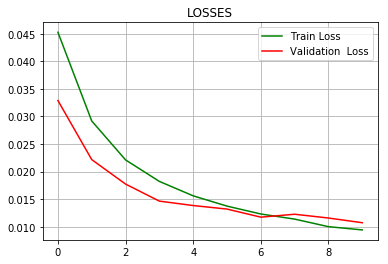

In [0]:
plt.title("LOSSES")
plt.plot(train_resnet_losses, label = "Train Loss", color= "green")
plt.plot(valid_resnet_losses,  label = "Validation  Loss", color= "red")
plt.legend()
plt.grid()

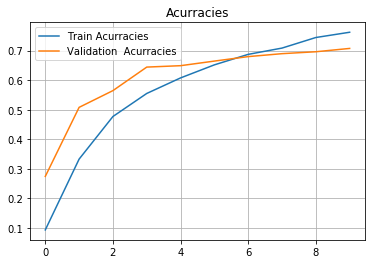

In [0]:
plt.title("Acurracies")
plt.plot(train_resnet_acurracies, label = "Train Acurracies")
plt.plot(valid_resnet_acurracies, label = "Validation  Acurracies")
plt.legend()
plt.grid()

In [0]:
def test_model(criterion, model):
    test_loss = 0.0
    test_acc  = 0.0
    test_predcs_all = np.array([])
    test_labels_all = np.array([])
    test_acc_5 = 0.0  
  
    # testing the current model within the current epoch.
    for test_images, test_labels in test_loader: 
    
        # registering test images and labels 
        # to device to benefit from GPU
        test_images = test_images.to( device )
        test_labels = test_labels.to( device )
         
    
        # calculating loss for test 
        # dataset for the current batch.
        test_labels_head = model.propagate_forward(test_images)
        loss = criterion(test_labels_head, test_labels)
        
        # calculating acurracy for the cur-
        # rent batch for the test dataset.
        predictions = torch.max( test_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == test_labels )
    
        top5 = test_labels_head.topk(5, 1, True, True)[1]
    
        for i in range(top5.size()[0]):      
            for j in range(5):
                if (top5[i][j] == predictions[i]):
                    test_acc_5 += 1
                    break
      
        test_predcs_all = np.concatenate((test_predcs_all.ravel(), predictions.cpu().clone().detach().numpy().ravel()))
        test_labels_all = np.concatenate((test_labels_all.ravel(), test_labels.cpu().clone().detach().numpy().ravel()))
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        test_acc  += acurracy 
        test_loss += loss.item()

    return test_loss, test_acc, test_acc_5, test_predcs_all, test_labels_all

In [0]:
test_count = 1227
test_loss_resnet, test_acc_resnet, test_acc_5_resnet, test_pred_resnet, test_labels_resnet = test_model(criterion_resnet, resnet_model)

test_acc_resnet = float(test_acc_resnet.float()) / test_count 
print("Test Acurracy Top1: " + str( float(test_acc_resnet) ))    

test_acc_5_resnet = test_acc_5_resnet / test_count
print("Test Acurracy Top5: " + str( float(test_acc_5_resnet) ))    

test_loss_resnet = test_loss_resnet / test_count
print("Test Loss: " + str(test_loss_resnet))

Test Acurracy Top1: 0.6821515892420538
Test Acurracy Top5: 1.0
Test Loss: 0.01198774561613871


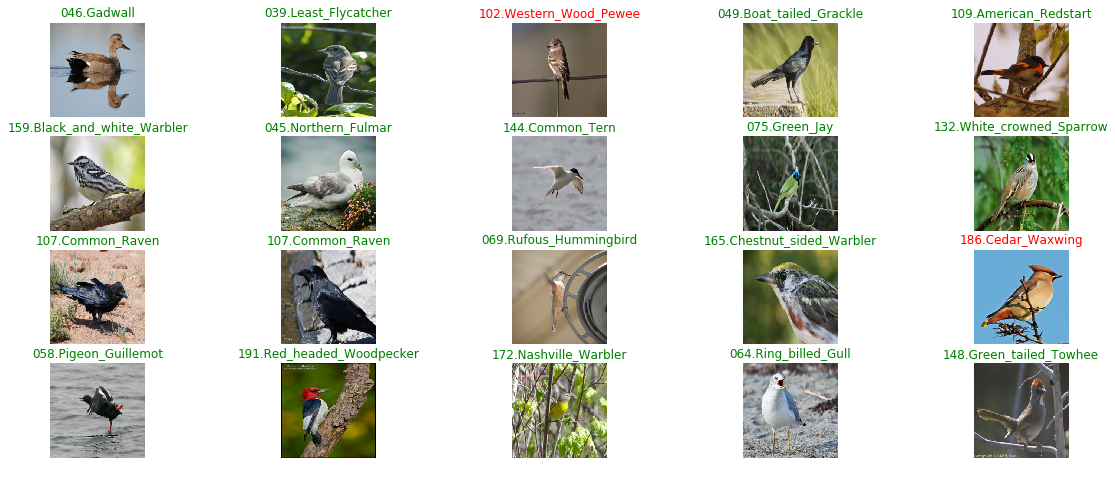

In [0]:
sample_iterator_resnet = iter(test_loader)
sample_images_resnet, sample_labels_resnet = sample_iterator_resnet.next()
sample_images_resnet = sample_images_resnet.to( device )
sample_labels_resnet = sample_labels_resnet.to( device )
sample_labels_resnet_head = resnet_model.propagate_forward(sample_images_resnet)
sample_predictions_resnet = torch.max( sample_labels_resnet_head , 1)[1] 

figure = plt.figure(figsize=(20,8))    

for i in range(20):
    axes = figure.add_subplot(4, 5, i+1)
    image = convert_img_cuda(sample_images_resnet[i])
    title = classes[ int(sample_predictions_resnet[i]) ]
    plt.imshow(image) 
    if (title == classes[int(sample_labels_resnet[i])]):
        plt.title(str(title), color="green")
    else:
        plt.title(str(title), color="red")
    plt.axis('off')

plt.show()